In [1]:
import numpy as np
import pandas as pd
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
import time
import warnings
warnings.filterwarnings('ignore')

from functools import partial
from scipy.optimize import bisect, brentq, newton
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, Lasso, ElasticNet, BayesianRidge, TheilSenRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [2]:
# Установка уровня журналирования для Optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [3]:
start_time = time.time()

1. Исходные данные

In [4]:
# Фиксация генератора случайных чисел
random_seed = 1912 
np.random.seed(random_seed)

# Значения токов фазы А в начале и конце ЛЭП для вычисления целевой переменной в начале и конце ЛЭП
A_N = [1800 + 1000j, 1500 + 1000j, 1800 + 1400j, 2200 + 1800j, 1200 + 1000j]
A_K = [1600 +  900j, 1400 +  950j, 1700 + 1350j, 2050 + 1700j, 1150 +  900j]

# Наибольшие значения модулей токов прямой последовательности в начале и конце ЛЭП для оптимизации целевой переменной
I1_N = [1200, 1000, 1200, 1400, 1000]
I1_K = [1100, 900, 1100, 1300, 900]

# Коэффициенты токов обратной и нулевой последовательности в начале и конце ЛЭП
k_N_2, k_K_2 = 0.100, 0.090
k_N_0, k_K_0 = 0.050, 0.045

# Отн. погрешности измерений значений элементов матрицы A_h и вектора b_d
k_A = 0.01
k_b = 0.05

# Относительный размер тестовой выборки
test_size = 0.3

2. Значения предикторов для прогноза целевой переменной (с учетом коэффициентов небаланса фазных токов)

In [5]:
# Комплексные операторы поворота фазных токов
b_rot = complex(-0.5, np.sqrt(3) / 2)
c_rot = complex(-0.5, -1 * np.sqrt(3) / 2)

A_complex_max = [val for a_n, a_k in zip(A_N, A_K) for val in [a_n, a_n * b_rot, a_n * c_rot, a_k, a_k * b_rot, a_k * c_rot]]

# A_complex_max = []
# for i in range(len(A_N)):
#     A_complex_max.extend([A_N[i], A_N[i] * b_rot, A_N[i] * c_rot, A_K[i], A_K[i] * b_rot, A_K[i] * c_rot])

# A_complex_max = [
#     A_N[0] * 1.00, A_N[0] * b_rot * 0.95, A_N[0] * c_rot * 1.00, A_K[0], A_K[0] * b_rot * 1.00, A_K[0] * c_rot * 1.05,
#     A_N[1] * 1.00, A_N[1] * b_rot * 0.97, A_N[1] * c_rot * 1.00, A_K[1], A_K[1] * b_rot * 1.00, A_K[1] * c_rot * 1.03,
#     A_N[2] * 1.00, A_N[2] * b_rot * 1.04, A_N[2] * c_rot * 1.00, A_K[2], A_K[2] * b_rot * 0.96, A_K[2] * c_rot * 1.00,
#     A_N[3] * 1.00, A_N[3] * b_rot * 1.00, A_N[3] * c_rot * 1.05, A_K[3], A_K[3] * b_rot * 1.00, A_K[3] * c_rot * 0.95,
#     A_N[4] * 1.00, A_N[4] * b_rot * 1.05, A_N[4] * c_rot * 1.00, A_K[4], A_K[4] * b_rot * 1.00, A_K[4] * c_rot * 0.95,
# ]

3. Загрузка датасетов

In [6]:
# Загрузка точных коэффициентов регрессии (для контроля обучения моделей)
z_complex_acc = pd.read_excel('C:\Datasets/dataset_z_powerlines.xlsx').astype(complex)
z_complex_acc.T

,0,1,2,3,4,5
z(1),0.400+0.060j,0.380+0.055j,0.360+0.050j,0.350+0.048j,0.330+0.045j,0.300+0.044j
z(2),0.200+0.025j,0.180+0.022j,0.160+0.020j,0.150+0.019j,0.140+0.016j,0.120+0.014j
z(3),0.180+0.022j,0.160+0.020j,0.150+0.018j,0.130+0.016j,0.120+0.015j,0.110+0.014j
z(4),0.160+0.020j,0.140+0.018j,0.130+0.016j,0.100+0.015j,0.090+0.014j,0.080+0.012j
z(5),0.150+0.018j,0.140+0.016j,0.130+0.015j,0.110+0.012j,0.100+0.012j,0.090+0.010j


In [7]:
# Загрузка датасета с данными из комплексных чисел
df_complex = pd.read_excel('C:\Datasets/dataset_voltage_1.xlsx').astype(complex)
df_complex

,a1_1_h,b1_1_h,c1_1_h,a2_1_h,b2_1_h,c2_1_h,a1_2_h,b1_2_h,c1_2_h,a2_2_h,...,a2_4_h,b2_4_h,c2_4_h,a1_5_h,b1_5_h,c1_5_h,a2_5_h,b2_5_h,c2_5_h,b_d
0,400.551003+150.206626j,-327.115056+269.115868j,-70.248269-422.324448j,383.020983+141.112994j,-311.523095+259.322351j,-69.035212-400.707738j,199.544548+119.726729j,-204.541582+113.548451j,3.937960-234.091501j,185.808949+110.480996j,...,579.711772+229.885703j,-492.695897+390.073689j,-90.409219-0614.5422340j,199.857361+99.928680j,-185.225242+122.295714j,-13.444449-223.987941j,189.876204+99.934844j,-181.668176+114.586226j,-8.323296-212.650035j,52.5736280+90.9818700j
1,402.897073+151.086402j,-330.721252+272.082667j,-70.152577-421.749159j,376.509043+138.713858j,-313.805916+261.222648j,-69.414095-402.906926j,198.676489+119.205894j,-204.628024+113.596438j,3.951636-234.904457j,185.748356+110.444968j,...,579.267648+229.709585j,-486.857554+385.451398j,-90.631903-0616.0558890j,198.900355+99.450177j,-186.688274+123.261687j,-13.377447-222.871660j,190.091421+100.048116j,-182.077586+114.844459j,-8.319270-212.547166j,52.0700980+90.6319940j
2,400.306319+150.114870j,-328.644700+270.374298j,-70.684486-424.946931j,383.170748+141.168170j,-314.358308+261.682478j,-68.995364-400.476440j,198.650539+119.190323j,-204.883330+113.738168j,3.960615-235.438243j,183.454454+109.081026j,...,580.538717+230.213629j,-487.131737+385.668472j,-91.010959-0618.6324630j,199.756671+99.878335j,-188.129102+124.212999j,-13.471689-224.441756j,189.110577+99.531883j,-183.283265+115.604935j,-8.417774-215.063845j,53.0669500+92.2428440j
3,403.836807+151.438803j,-332.855436+273.838448j,-70.582240-424.332241j,378.222061+139.344970j,-310.974773+258.865909j,-69.367150-402.634436j,201.758683+121.055210j,-203.157133+112.779893j,3.960431-235.427278j,183.853475+109.318282j,...,583.565870+231.414052j,-492.400176+389.839563j,-91.503133-0621.9779350j,200.494753+100.247376j,-186.879282+123.387801j,-13.534287-225.484654j,189.352013+99.658954j,-181.480592+114.467909j,-8.353137-213.412435j,51.8071840+90.1174660j
4,399.009638+149.628614j,-328.077618+269.907762j,-70.004927-420.861503j,380.630202+140.232180j,-313.281860+260.786406j,-68.942244-400.168113j,200.749613+120.449768j,-204.947354+113.773710j,3.917201-232.857471j,186.664029+110.989422j,...,576.199073+228.492736j,-486.211869+384.940201j,-91.182409-0619.7978690j,199.432065+99.716033j,-185.353794+122.380591j,-13.536987-225.529635j,189.411923+99.690486j,-182.769676+115.280992j,-8.460957-216.167114j,50.2841900+87.2405320j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,823.897178+308.961442j,-701.482206+577.105789j,-150.761509-906.360705j,795.798866+293.189056j,-680.337269+566.335732j,-144.303345-837.593817j,407.933011+244.759806j,-424.759897+235.799626j,8.264801-491.299968j,392.869372+233.598005j,...,1230.156666+487.820747j,-1033.186847+817.987338j,-192.362883-1307.555988j,419.614478+209.807239j,-404.612891+267.147295j,-28.276893-471.100228j,390.295748+205.418815j,-389.646344+245.767338j,-17.876219-456.715534j,103.731474+193.358890j
996,832.201246+312.075467j,-702.373858+577.839346j,-149.925376-901.333973j,793.122792+292.203134j,-675.161705+562.027417j,-145.412287-844.030555j,407.748837+244.649302j,-425.956425+236.463862j,8.257573-490.870321j,392.132298+233.159745j,...,1224.999386+485.775618j,-1042.461502+825.330201j,-191.446353-1301.326016j,419.786755+209.893378j,-404.553219+267.107897j,-27.967804-465.950717j,390.822486+205.696045j,-384.244159+242.359939j,-18.030577-460.659203j,100.711558+186.344249j
997,833.086681+312.407506j,-709.793681+583.943596j,-150.041396-902.031469j,797.558742+293.837431j,-680.334779+566.333659j,-144.835953-840.685283j,410.349122+246.209473j,-425.174303+236.029677j,8.404710-499.616831j,388.561630+231.036645j,...,1239.560328+491.549785j,-1029.016480+814.685604j,-189.398991-1287.409404j,416.985042+208.492521j,-405.890277+267.990694j,-28.308397-471.625091j,392.223120+206.433221j,-385.384418+243.079151j,-17.741701-453.278766j,100.588959+1

4. Преобразование признаков в симметричные составляющие

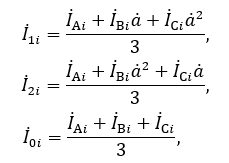

In [8]:
# Функция преобразования в симметричные составляющие
def apply_operations(row):
    df_row = []
    for i in range(0, len(row), 3):
        if i + 2 < len(row):  # Проверяем, что есть достаточно элементов для выполнения операции
            avg = (row[i] + row[i + 1] + row[i + 2]) / 3
            df_row.extend([row[i] + row[i + 1] * b_rot + row[i + 2] * c_rot,
                             row[i] + row[i + 1] * c_rot + row[i + 2] * b_rot,
                             avg])
    return df_row


In [9]:
# Преобразование датасета df_complex в симметричные составляющие
df_copy = df_complex.copy()
df_symcomp = df_copy.apply(apply_operations, axis=1, result_type='expand')
df_symcomp['b_d'] = df_copy['b_d']
df_symcomp

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,b_d
0,0.4277860+4.3577530j,1198.037545+449.264079j,1.062559-1.000652j,1.6973120+1.8050200j,1144.902962+421.806354j,0.820892-0.090798j,-1.218671-0.550325j,600.911388+360.546833j,-0.353024-0.272107j,-0.332671+0.307985j,...,1.241419-6.270507j,1741.287241+690.510457j,-1.131115+1.805719j,-0.698236+2.008263j,599.082648+299.541324j,0.395890-0.587849j,1.4770250-1.1543210j,568.266854+299.087818j,-0.038423+0.623678j,52.5736280+90.9818700j
1,2.4580010+0.2605560j,1204.209975+451.578740j,0.674414+0.473303j,-7.0340340-2.0935280j,1143.272131+421.205522j,-2.236990-0.990140j,-2.795946-0.775381j,600.825312+360.495187j,-0.666633-0.700708j,2.548170-2.827038j,...,0.681624+1.870350j,1735.343129+688.153310j,0.592730-0.298302j,-0.827056-0.836415j,598.693487+299.346744j,-0.388455-0.053265j,1.7603840-1.5796470j,568.819313+299.378586j,-0.101812+0.781803j,52.0700980+90.6319940j
2,-2.1949360+4.0010870j,1202.136759+450.801285j,0.325711-1.485921j,1.4011390-1.9253910j,1148.294027+423.055694j,-0.060974+0.791403j,-3.283746-0.823801j,601.507538+360.904523j,-0.757392-0.836584j,-2.163789-0.335250j,...,-0.140057+3.644968j,1739.360188+689.746281j,0.798674-0.916787j,-1.386809-1.265043j,602.500940+301.250470j,-0.614706-0.116807j,-1.4064670-2.1766190j,571.328661+300.699295j,-0.863487+0.024324j,53.0669500+92.2428440j
3,0.9220920-0.4495510j,1210.189198+453.820949j,0.133044+0.315003j,-4.4830810+1.9908940j,1141.269126+420.467573j,-0.706621-1.474519j,-0.199222+3.009830j,602.913291+361.747974j,0.853994-0.530725j,-2.166235-0.378728j,...,-0.742134+0.296214j,1751.777181+694.670262j,-0.112480-0.241440j,-1.430871+1.174633j,602.833945+301.416973j,0.027061-0.616492j,0.3161710-0.8015570j,568.221584+299.063992j,-0.160572+0.238143j,51.8071840+90.1174660j
4,-0.1728210+1.6079790j,1196.274643+448.602991j,0.309031-0.441709j,-0.6611500-1.6812810j,1144.145657+421.527347j,-0.531301+0.283491j,1.073281-0.890362j,601.456098+360.873659j,-0.093514+0.455335j,-0.162682+3.015381j,...,-5.232480+3.816022j,1735.024905+688.027117j,-0.398402-2.121644j,-2.421638+2.492835j,600.176549+300.088275j,0.180428-1.144337j,-2.0152400-0.8222320j,572.069719+301.089326j,-0.606237-0.398546j,50.2841900+87.2405320j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-34.700634-3.349214j,2534.738704+950.527014j,-9.448845-6.764492j,-7.719481-35.400898j,2423.957828+893.037094j,-9.613916+7.310324j,-13.506161-2.500412j,1245.867278+747.520367j,-2.854029-3.580179j,0.099713+4.339017j,...,2.157014+4.430160j,3683.706048+1460.779985j,1.535645-0.582635j,-3.281740-14.132829j,1275.400479+637.700240j,-4.425102+1.951435j,-14.310984-11.069461j,1202.425043+632.855286j,-5.742272-1.843127j,103.731474+193.358890j
996,-22.650808-4.611639j,2539.352534+952.257200j,-6.699329-3.806386j,-14.272136-25.571751j,2421.091711+891.981157j,-9.150400+3.399999j,-13.291617-4.187822j,1246.488142+747.892885j,-3.316672-3.252386j,-2.775500+3.580115j,...,0.215003-13.227212j,3683.691622+1460.774264j,-2.969489+3.259935j,1.199885-16.817749j,1270.894649+635.447324j,-4.244756+3.683519j,-16.872581-2.304588j,1200.792291+631.995942j,-3.817417-4.201073j,100.711558+186.344249j
997,-23.887937-13.308256j,2549.896376+956.211141j,-8.916132-1.893456j,-8.370039-32.742344j,2428.658255+894.768831j,-9.203996+6.495269j,-18.354646+2.512611j,1255.822482+753.493489j,-2.140157-5.792560j,-3.523441-5.557526j,...,28.300385+0.781610j,3669.235742+1455.041760j,7.048286+6.275328j,-6.44168-016.685780j,1274.610438+637.305219j,-5.737877+1.619375j,-9.2774670-6.8549040j,1196.849826+629.920961j,-3.634333-1.255464j,100.588959+186.420469j
998,-21.702684-20.519094j,2551.008729+956.628273j,-9.947782+0.396444j,-2.351410-32.912037j,2417.629521+890.705613j,-7.714018+7.839903j,-11.477045-1.697458j,1262.288534+757.373120j,-2.299573-3.109334j,-2.468457-1.626814j,...,8.829772+7.050877j,3698.341873+1466.583846j,3.754101+0.305557j,-1.454966-10.266770j,1267.715732+633.857866j,-3.028798+1.665363j,-7.1481480-4.6341710j,1207

In [10]:
# Преобразвание датасета A_complex_max в симметричные составляющие
A_symcomp_max = apply_operations(A_complex_max)

5. Попарные графики рассеяния модулей значений переменных датасета

In [11]:
# df_modul = df_symcomp.applymap(lambda x: abs(x))
# sns.pairplot(df_modul, kind="reg")
# plt.show()

6. Выделение комплексной матрицы признаков и комплексного вектора целевой переменной из датасета df_complex

In [12]:
A_complex = df_symcomp.iloc[:, :-1].values
b_complex = df_symcomp.iloc[:, -1].values
cond_A_complex = np.linalg.cond(A_complex.T @ A_complex)
det_A_complex = np.linalg.det(A_complex.T @ A_complex)

print(f'Число обусловленности матрицы A_complex: cond(A_complex) = {cond_A_complex:.{2}e}')
print(f'Определитель матрицы A_complex:" det(A_complex) = {det_A_complex:.{1}e}')

Число обусловленности матрицы A_complex: cond(A_complex) = 1.19e+07
Определитель матрицы A_complex:" det(A_complex) = 4.7e+134+5.0e+134j


7. Разбиение на обучающую и тестовые выборки

In [13]:
A_train_complex, A_test_complex, b_train_complex, b_test_complex = train_test_split(A_complex, 
                                                                                    b_complex,
                                                                                    test_size=test_size,
                                                                                    random_state=random_seed)

8. Формирование вещественной матрицы A_train признаков и вещественного вектора b_train целевой переменной

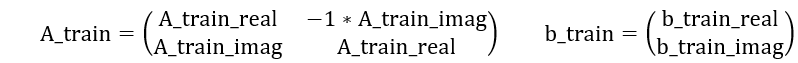


In [14]:
A_train_real = A_train_complex.real
A_train_imag = A_train_complex.imag
A_train_1 = pd.concat([pd.DataFrame(A_train_real), pd.DataFrame(A_train_imag)], axis=0)
A_train_2 = pd.concat([-1 * pd.DataFrame(A_train_imag), pd.DataFrame(A_train_real)], axis=0)
index_train = np.arange(A_train_1.shape[0])
A_train_1.index = index_train
A_train_2.index = index_train 
A_train = pd.merge(A_train_1, A_train_2, left_index=True, right_index=True)
A_train.columns = [f'A_{i+1}' for i in range(A_train.shape[1])]

In [15]:
b_train_real = b_train_complex.real
b_train_imag = b_train_complex.imag
b_train = pd.concat([pd.DataFrame(b_train_real), pd.DataFrame(b_train_imag)], axis=0)
b_train.index = index_train
b_train.columns = ['b']

9. Формирование вещественной матрицы A_test признаков и вещественного вектора b_test целевой переменной

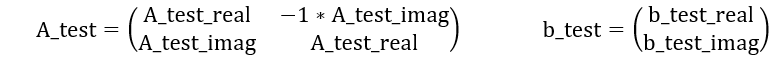

In [16]:
A_test_real = A_test_complex.real
A_test_imag = A_test_complex.imag
A_test_1 = pd.concat([pd.DataFrame(A_test_real), pd.DataFrame(A_test_imag)], axis=0)
A_test_2 = pd.concat([-1 * pd.DataFrame(A_test_imag), pd.DataFrame(A_test_real)], axis=0)
index_test = np.arange(A_test_1.shape[0])
A_test_1.index = index_test
A_test_2.index = index_test 
A_test = pd.merge(A_test_1, A_test_2, left_index=True, right_index=True)
A_test.columns = [f'A_{i+1}' for i in range(A_test.shape[1])]

In [17]:
b_test_real = b_test_complex.real
b_test_imag = b_test_complex.imag
b_test = pd.concat([pd.DataFrame(b_test_real), pd.DataFrame(b_test_imag)], axis=0)
b_test.index = index_test
b_test.columns = ['b']

10. Формирование вещественного вектора A_max для прогноза целевой переменной

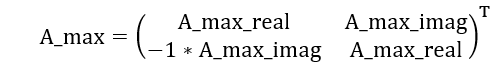

In [18]:
A_max_real = np.array(A_symcomp_max).real
A_max_imag = np.array(A_symcomp_max).imag
A_max_1 = pd.concat([pd.DataFrame(A_max_real), -1 * pd.DataFrame(A_max_imag)], axis=0)
A_max_2 = pd.concat([pd.DataFrame(A_max_imag), pd.DataFrame(A_max_real)], axis=0)
index_max = np.arange(A_max_1.shape[0])
A_max_1.index = index_max
A_max_2.index = index_max 
A_max = pd.merge(A_max_1, A_max_2, left_index=True, right_index=True)
A_max = A_max.T
A_max

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0_x,4.547474e-13,5400.0,0.0,2.273737e-13,4800.0,3.789561e-14,2.273737e-13,4500.0,0.0,2.273737e-13,...,-0.000000e+00,-2.273737e-13,-5100.0,-0.000000e+00,-2.273737e-13,-3000.0,-0.0,-4.547474e-13,-2700.0,-0.000000e+00
0_y,2.273737e-13,3000.0,0.0,3.410605e-13,2700.0,0.000000e+00,2.273737e-13,3000.0,0.0,1.136868e-13,...,7.579123e-14,4.547474e-13,6150.0,-7.579123e-14,2.273737e-13,3600.0,0.0,2.273737e-13,3450.0,3.789561e-14


11. Масштабирование признаков и вектора A_max

In [19]:
sc = MaxAbsScaler()    # MaxAbsScaler()    MinMaxScaler()    StandardScaler()

# Переход к привычным обозначениям X и y для признаков и целевых переменных
X_train_std = sc.fit_transform(A_train) 
X_test_std = sc.transform(A_test)

y_train = b_train
y_test = b_test

X_test_std.shape

(600, 60)

In [20]:
A_max_std = sc.transform(A_max)
pd.DataFrame(A_max_std).round(3)

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.0,2.117,0.0,0.0,1.972,0.0,0.0,3.565,0.0,0.0,...,-0.0,-0.0,-1.379,-0.0,-0.0,-2.352,-0.0,-0.0,-2.237,-0.0
1,0.0,1.176,0.0,0.0,1.109,0.0,0.0,2.377,0.0,0.0,...,0.0,0.0,1.663,-0.0,0.0,2.823,0.0,0.0,2.858,0.0


12. Обучение моделей регрессоров

In [21]:
metrics = {}
metrics_opt = {}

12.1 LinearRegression

In [22]:
lr = LinearRegression()
model_lr = lr.fit(X_train_std, y_train)

y_lr_pred = model_lr.predict(X_test_std)
y_lr_pred_train = model_lr.predict(X_train_std)

rmse_lr_train = np.sqrt(mean_squared_error(y_train, y_lr_pred_train)).round(3)
rmse_lr_test = np.sqrt(mean_squared_error(y_test, y_lr_pred)).round(3)
mae_lr_train = mean_absolute_error(y_train, y_lr_pred_train).round(3)
mae_lr_test = mean_absolute_error(y_test, y_lr_pred).round(3)
r2_lr_train = r2_score(y_train, y_lr_pred_train).round(3)
r2_lr_test = r2_score(y_test, y_lr_pred).round(3)

b_max_lr = model_lr.predict(A_max_std)[:].flatten()
b_max_lr_complex = complex(b_max_lr[0], b_max_lr[1])
b_max_lr_modul = np.abs(b_max_lr_complex)
b_max_lr_arg = np.angle(b_max_lr_complex) * 180 / np.pi
metrics['LinearRegr'] = (str(r2_lr_train), str(r2_lr_test), np.round(b_max_lr_complex, 1), str(b_max_lr_modul.round(1)), str(b_max_lr_arg.round(1)))
metrics_opt['LinearRegr'] = (str(r2_lr_train), str(r2_lr_test), np.round(b_max_lr_complex, 1), str(b_max_lr_modul.round(1)), str(b_max_lr_arg.round(1)))

print(f'RMSE train: {rmse_lr_train}')
print(f'RMSE test:  {rmse_lr_test}')
print()
print(f'MAE train:  {mae_lr_train}')
print(f'MAE test:   {mae_lr_test}')
print()
print(f'R2 train:   {r2_lr_train}')
print(f'R2 test:    {r2_lr_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {np.round(b_max_lr_complex, 1)}')
print(f'b max_modul:   {b_max_lr_modul.round(1)}')
print()
z_lr_real = model_lr.coef_.flatten()[:len(A_symcomp_max)]
z_lr_imag = model_lr.coef_.flatten()[len(A_symcomp_max):]
print(f'Свободный член регрессии  a0 =  {model_lr.intercept_.round(3)}')
print('Масштабированные коэффициенты регрессии:')
pd.DataFrame({'z_lr_real': z_lr_real, 'z_lr_imag': z_lr_imag}).T.round(1)

RMSE train: 3.165
RMSE test:  3.385

MAE train:  2.522
MAE test:   2.683

R2 train:   0.993
R2 test:    0.991

Прогноз целевой переменной:
b max_complex: (80.2+268.8j)
b max_modul:   280.5

Свободный член регрессии  a0 =  [12.394]
Масштабированные коэффициенты регрессии:


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
z_lr_real,-1.3,42.6,2.6,1.2,115.9,2.6,-1.8,-104.4,0.7,-0.1,...,1.1,0.3,156.8,0.5,-0.2,19.7,0.9,0.9,7.7,1.9
z_lr_imag,2.0,34.3,-1.0,0.7,85.8,0.7,1.6,-34.0,-1.5,-0.4,...,1.3,0.4,202.7,0.2,1.1,-27.0,0.3,1.8,20.1,-0.1


12.2 Ridge

In [23]:
# GridSearchCV
rid = Ridge()
rid_parameters = {'alpha': np.logspace(-5, 3, num=101), 
                  'random_state':[1, 7, 42, 100]
}
model_rid = GridSearchCV(estimator=rid,
                   param_grid=rid_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_rid.fit(X_train_std, y_train)

y_rid_pred = model_rid.predict(X_test_std)
y_rid_pred_train = model_rid.predict(X_train_std)

rmse_rid_train = np.sqrt(mean_squared_error(y_train, y_rid_pred_train)).round(3)
rmse_rid_test = np.sqrt(mean_squared_error(y_test, y_rid_pred)).round(3)
mae_rid_train = mean_absolute_error(y_train, y_rid_pred_train).round(3)
mae_rid_test = mean_absolute_error(y_test, y_rid_pred).round(3)
r2_rid_train = r2_score(y_train, y_rid_pred_train).round(3)
r2_rid_test = r2_score(y_test, y_rid_pred).round(3)

b_max_rid = model_rid.predict(A_max_std)[:].flatten()
b_max_rid_complex = complex(b_max_rid[0], b_max_rid[1])
b_max_rid_modul = np.abs(b_max_rid_complex)
b_max_rid_arg = np.angle(b_max_rid_complex) * 180 / np.pi
metrics['Ridge'] = (str(r2_rid_train), str(r2_rid_test), np.round(b_max_rid_complex, 1), str(b_max_rid_modul.round(1)), str(b_max_rid_arg.round(1)))

print('\u0332'.join('GridSearchCV'))
print(f'RMSE train: {rmse_rid_train}')
print(f'RMSE test:  {rmse_rid_test}')
print()
print(f'MAE train:  {mae_rid_train}')
print(f'MAE test:   {mae_rid_test}')
print()
print(f'R2 train:   {r2_rid_train}')
print(f'R2 test:    {r2_rid_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {np.round(b_max_rid_complex, 1)}')
print(f'b max_modul:   {b_max_rid_modul.round(1)}')
print(model_rid.best_params_)
print()


# OPTUNA
rid_opt_parameters = {
    'alpha': (1e-5, 1e3),
    'random_state': (1, 100)
}

def objective(trial):
    # Определение гиперпараметров для оптимизации
    params = {}
    for param_name, param_range in rid_opt_parameters.items():
        if param_name == 'random_state':
            params[param_name] = trial.suggest_int(param_name, *param_range)
        else:
            params[param_name] = trial.suggest_uniform(param_name, *param_range)

    # Создание и обучение модели с определенными гиперпараметрами
    rid_opt = Ridge(**params)
    rid_opt.fit(X_train_std, y_train)

    y_rid_opt_pred = rid_opt.predict(X_test_std)
    r2 = r2_score(y_test, y_rid_opt_pred)

    return r2

# Создание объекта Optuna Study и запуск оптимизации
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=random_seed))  # maximize, так как ищем максимум функции
study.optimize(objective, n_trials=100)

# Получение оптимальных значений гиперпараметров из объекта study
optimal_params = study.best_params

# Создание окончательной модели с оптимальными гиперпараметрами
final_rid = Ridge(**optimal_params)
final_rid.fit(X_train_std, y_train)

y_rid_opt_pred = final_rid.predict(X_test_std)
y_rid_opt_pred_train = final_rid.predict(X_train_std)

rmse_rid_opt_train = np.sqrt(mean_squared_error(y_train, y_rid_opt_pred_train)).round(3)
rmse_rid_opt_test = np.sqrt(mean_squared_error(y_test, y_rid_opt_pred)).round(3)
mae_rid_opt_train = mean_absolute_error(y_train, y_rid_opt_pred_train).round(3)
mae_rid_opt_test = mean_absolute_error(y_test, y_rid_opt_pred).round(3)
r2_rid_opt_train = r2_score(y_train, y_rid_opt_pred_train).round(3)
r2_rid_opt_test = r2_score(y_test, y_rid_opt_pred).round(3)

b_max_rid_opt = final_rid.predict(A_max_std)[:].flatten()
b_max_rid_opt_complex = complex(b_max_rid_opt[0], b_max_rid_opt[1])
b_max_rid_opt_modul = np.abs(b_max_rid_opt_complex)
b_max_rid_opt_arg = np.angle(b_max_rid_opt_complex) * 180 / np.pi
metrics_opt['Ridge'] = (str(r2_rid_opt_train), str(r2_rid_opt_test), np.round(b_max_rid_opt_complex, 1), str(b_max_rid_opt_modul.round(1)), str(b_max_rid_opt_arg.round(1)))

print('\u0332'.join('OPTUNA'))
print(f'RMSE train: {rmse_rid_opt_train}')
print(f'RMSE test:  {rmse_rid_opt_test}')
print()
print(f'MAE train:  {mae_rid_opt_train}')
print(f'MAE test:   {mae_rid_opt_test}')
print()
print(f'R2 train:   {r2_rid_opt_train}')
print(f'R2 test:    {r2_rid_opt_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {np.round(b_max_rid_opt_complex, 1)}')
print(f'b max_modul:   {b_max_rid_opt_modul.round(1)}')
print(optimal_params)

G̲r̲i̲d̲S̲e̲a̲r̲c̲h̲C̲V
RMSE train: 3.17
RMSE test:  3.359

MAE train:  2.531
MAE test:   2.676

R2 train:   0.992
R2 test:    0.991

Прогноз целевой переменной:
b max_complex: (110.5+340.3j)
b max_modul:   357.8
{'alpha': 0.0017378008287493763, 'random_state': 1}

O̲P̲T̲U̲N̲A
RMSE train: 3.225
RMSE test:  3.34

MAE train:  2.573
MAE test:   2.674

R2 train:   0.992
R2 test:    0.991

Прогноз целевой переменной:
b max_complex: (159.9+481.2j)
b max_modul:   507.1
{'alpha': 0.05194769842700686, 'random_state': 5}


12.3 SGDRegressor

In [24]:
# GridSearchCV
sgd = SGDRegressor()
sgd_parameters = {'alpha': np.logspace(-5, 3, num=101),
                  'l1_ratio': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9],
                  'random_state': [1, 7, 42, 100]
                 }
model_sgd = GridSearchCV(estimator=sgd,
                   param_grid=sgd_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_sgd.fit(X_train_std, y_train)

y_sgd_pred = model_sgd.predict(X_test_std)
y_sgd_pred_train = model_sgd.predict(X_train_std)

rmse_sgd_train = np.sqrt(mean_squared_error(y_train, y_sgd_pred_train)).round(3)
rmse_sgd_test = np.sqrt(mean_squared_error(y_test, y_sgd_pred)).round(3)
mae_sgd_train = mean_absolute_error(y_train, y_sgd_pred_train).round(3)
mae_sgd_test = mean_absolute_error(y_test, y_sgd_pred).round(3)
r2_sgd_train = r2_score(y_train, y_sgd_pred_train).round(3)
r2_sgd_test = r2_score(y_test, y_sgd_pred).round(3)

b_max_sgd = model_sgd.predict(A_max_std).flatten()
b_max_sgd_complex = complex(b_max_sgd[0], b_max_sgd[1])
b_max_sgd_modul = np.abs(b_max_sgd_complex)
b_max_sgd_arg = np.angle(b_max_sgd_complex) * 180 / np.pi
metrics['SGDRegr'] = (str(r2_sgd_train), str(r2_sgd_test), np.round(b_max_sgd_complex, 1), str(b_max_sgd_modul.round(1)), str(b_max_sgd_arg.round(1)))

print('\u0332'.join('GridSearchCV'))
print(f'RMSE train: {rmse_sgd_train}')
print(f'RMSE test:  {rmse_sgd_test}')
print()
print(f'MAE train:  {mae_sgd_train}')
print(f'MAE test:   {mae_sgd_test}')
print()
print(f'R2 train:   {r2_sgd_train}')
print(f'R2 test:    {r2_sgd_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {np.round(b_max_sgd_complex, 1)}')
print(f'b max_modul:   {b_max_sgd_modul.round(1)}')
print(model_sgd.best_params_)
print()


# OPTUNA
sgd_opt_parameters = {
    'alpha': (1e-5, 1e3),
    'l1_ratio': (0.05, 1),
    'random_state': (1, 100)
}

def objective(trial):
    # Определение гиперпараметров для оптимизации
    params = {}
    for param_name, param_range in sgd_opt_parameters.items():
        if param_name == 'random_state':
            params[param_name] = trial.suggest_int(param_name, *param_range)
        else:
            params[param_name] = trial.suggest_uniform(param_name, *param_range)

    # Создание и обучение модели с определенными гиперпараметрами
    sgd_opt = SGDRegressor(**params)
    sgd_opt.fit(X_train_std, y_train)

    y_sgd_opt_pred = sgd_opt.predict(X_test_std)
    r2 = r2_score(y_test, y_sgd_opt_pred)

    return r2

# Создание объекта Optuna Study и запуск оптимизации
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=random_seed))  # maximize, так как ищем максимум функции
study.optimize(objective, n_trials=100)

# Получение оптимальных значений гиперпараметров из объекта study
optimal_params = study.best_params

# Создание окончательной модели с оптимальными гиперпараметрами
final_sgd = SGDRegressor(**optimal_params)
final_sgd.fit(X_train_std, y_train)

y_sgd_opt_pred = final_sgd.predict(X_test_std)
y_sgd_opt_pred_train = final_sgd.predict(X_train_std)

rmse_sgd_opt_train = np.sqrt(mean_squared_error(y_train, y_sgd_opt_pred_train)).round(3)
rmse_sgd_opt_test = np.sqrt(mean_squared_error(y_test, y_sgd_opt_pred)).round(3)
mae_sgd_opt_train = mean_absolute_error(y_train, y_sgd_opt_pred_train).round(3)
mae_sgd_opt_test = mean_absolute_error(y_test, y_sgd_opt_pred).round(3)
r2_sgd_opt_train = r2_score(y_train, y_sgd_opt_pred_train).round(3)
r2_sgd_opt_test = r2_score(y_test, y_sgd_opt_pred).round(3)

b_max_sgd_opt = final_sgd.predict(A_max_std).flatten()
b_max_sgd_opt_complex = complex(b_max_sgd_opt[0], b_max_sgd_opt[1])
b_max_sgd_opt_modul = np.abs(b_max_sgd_opt_complex)
b_max_sgd_opt_arg = np.angle(b_max_sgd_opt_complex) * 180 / np.pi
metrics_opt['SGDRegr'] = (str(r2_sgd_opt_train), str(r2_sgd_opt_test), np.round(b_max_sgd_opt_complex, 1), str(b_max_sgd_opt_modul.round(1)), str(b_max_sgd_opt_arg.round(1)))

print('\u0332'.join('OPTUNA'))
print(f'RMSE train: {rmse_sgd_opt_train}')
print(f'RMSE test:  {rmse_sgd_opt_test}')
print()
print(f'MAE train:  {mae_sgd_opt_train}')
print(f'MAE test:   {mae_sgd_opt_test}')
print()
print(f'R2 train:   {r2_sgd_opt_train}')
print(f'R2 test:    {r2_sgd_opt_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {np.round(b_max_sgd_opt_complex, 1)}')
print(f'b max_modul:   {b_max_sgd_opt_modul.round(1)}')
print(optimal_params)

G̲r̲i̲d̲S̲e̲a̲r̲c̲h̲C̲V
RMSE train: 3.343
RMSE test:  3.424

MAE train:  2.66
MAE test:   2.753

R2 train:   0.992
R2 test:    0.991

Прогноз целевой переменной:
b max_complex: (116.9+422.4j)
b max_modul:   438.2
{'alpha': 1e-05, 'l1_ratio': 0.05, 'random_state': 1}

O̲P̲T̲U̲N̲A
RMSE train: 4.691
RMSE test:  4.655

MAE train:  3.693
MAE test:   3.665

R2 train:   0.984
R2 test:    0.983

Прогноз целевой переменной:
b max_complex: (62.8+293.2j)
b max_modul:   299.9
{'alpha': 0.12368651434137945, 'l1_ratio': 0.5444514401194614, 'random_state': 58}


12.4 Lasso

In [25]:
# GridSearchCV
lass = Lasso()
lass_parameters = {'alpha': np.logspace(-5, 3, num=101), 
                  'random_state':[1, 7, 42, 100]
}
model_lass = GridSearchCV(estimator=lass,
                   param_grid=lass_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_lass.fit(X_train_std, y_train)

y_lass_pred = model_lass.predict(X_test_std)
y_lass_pred_train = model_lass.predict(X_train_std)

rmse_lass_train = np.sqrt(mean_squared_error(y_train, y_lass_pred_train)).round(3)
rmse_lass_test = np.sqrt(mean_squared_error(y_test, y_lass_pred)).round(3)
mae_lass_train = mean_absolute_error(y_train, y_lass_pred_train).round(3)
mae_lass_test = mean_absolute_error(y_test, y_lass_pred).round(3)
r2_lass_train = r2_score(y_train, y_lass_pred_train).round(3)
r2_lass_test = r2_score(y_test, y_lass_pred).round(3)

b_max_lass = model_lass.predict(A_max_std)[:].flatten()
b_max_lass_complex = complex(b_max_lass[0], b_max_lass[1])
b_max_lass_modul = np.abs(b_max_lass_complex)
b_max_lass_arg = np.angle(b_max_lass_complex) * 180 / np.pi
metrics['Lasso'] = (str(r2_lass_train), str(r2_lass_test), np.round(b_max_lass_complex, 1), str(b_max_lass_modul.round(1)), str(b_max_lass_arg.round(1)))

print('\u0332'.join('GridSearchCV'))
print(f'RMSE train: {rmse_lass_train}')
print(f'RMSE test:  {rmse_lass_test}')
print()
print(f'MAE train:  {mae_lass_train}')
print(f'MAE test:   {mae_lass_test}')
print()
print(f'R2 train:   {r2_lass_train}')
print(f'R2 test:    {r2_lass_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {np.round(b_max_lass_complex, 1)}')
print(f'b max_modul:   {b_max_lass_modul.round(1)}')
print(model_lass.best_params_)
print()


# OPTUNA
lass_opt_parameters = {
    'alpha': (1e-5, 1e3),
    'random_state': (1, 100)
}

def objective(trial):
    # Определение гиперпараметров для оптимизации
    params = {}
    for param_name, param_range in lass_opt_parameters.items():
        if param_name == 'random_state':
            params[param_name] = trial.suggest_int(param_name, *param_range)
        else:
            params[param_name] = trial.suggest_uniform(param_name, *param_range)

    # Создание и обучение модели с определенными гиперпараметрами
    lass_opt = Lasso(**params)
    lass_opt.fit(X_train_std, y_train)

    y_lass_opt_pred = lass_opt.predict(X_test_std)
    r2 = r2_score(y_test, y_lass_opt_pred)

    return r2

# Создание объекта Optuna Study и запуск оптимизации
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=random_seed))  # maximize, так как ищем максимум функции
study.optimize(objective, n_trials=100)

# Получение оптимальных значений гиперпараметров из объекта study
optimal_params = study.best_params

# Создание окончательной модели с оптимальными гиперпараметрами
final_lass = Lasso(**optimal_params)
final_lass.fit(X_train_std, y_train)

y_lass_opt_pred = final_lass.predict(X_test_std)
y_lass_opt_pred_train = final_lass.predict(X_train_std)

rmse_lass_opt_train = np.sqrt(mean_squared_error(y_train, y_lass_opt_pred_train)).round(3)
rmse_lass_opt_test = np.sqrt(mean_squared_error(y_test, y_lass_opt_pred)).round(3)
mae_lass_opt_train = mean_absolute_error(y_train, y_lass_opt_pred_train).round(3)
mae_lass_opt_test = mean_absolute_error(y_test, y_lass_opt_pred).round(3)
r2_lass_opt_train = r2_score(y_train, y_lass_opt_pred_train).round(3)
r2_lass_opt_test = r2_score(y_test, y_lass_opt_pred).round(3)

b_max_lass_opt = final_lass.predict(A_max_std)[:].flatten()
b_max_lass_opt_complex = complex(b_max_lass_opt[0], b_max_lass_opt[1])
b_max_lass_opt_modul = np.abs(b_max_lass_opt_complex)
b_max_lass_opt_arg = np.angle(b_max_lass_opt_complex) * 180 / np.pi
metrics_opt['Lasso'] = (str(r2_lass_opt_train), str(r2_lass_opt_test), np.round(b_max_lass_opt_complex, 1), str(b_max_lass_opt_modul.round(1)), str(b_max_lass_opt_arg.round(1)))

print('\u0332'.join('OPTUNA'))
print(f'RMSE train: {rmse_lass_opt_train}')
print(f'RMSE test:  {rmse_lass_opt_test}')
print()
print(f'MAE train:  {mae_lass_opt_train}')
print(f'MAE test:   {mae_lass_opt_test}')
print()
print(f'R2 train:   {r2_lass_opt_train}')
print(f'R2 test:    {r2_lass_opt_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {np.round(b_max_lass_opt_complex, 1)}')
print(f'b max_modul:   {b_max_lass_opt_modul.round(1)}')
print(optimal_params)

G̲r̲i̲d̲S̲e̲a̲r̲c̲h̲C̲V
RMSE train: 3.242
RMSE test:  3.335

MAE train:  2.588
MAE test:   2.669

R2 train:   0.992
R2 test:    0.991

Прогноз целевой переменной:
b max_complex: (363.4+505.4j)
b max_modul:   622.5
{'alpha': 0.00047863009232263805, 'random_state': 1}

O̲P̲T̲U̲N̲A
RMSE train: 3.511
RMSE test:  3.608

MAE train:  2.774
MAE test:   2.856

R2 train:   0.991
R2 test:    0.99

Прогноз целевой переменной:
b max_complex: (223+393.5j)
b max_modul:   452.3
{'alpha': 0.05194769842700686, 'random_state': 5}


12.5 ElasticNet

In [26]:
# GridSearchCV
en = ElasticNet()
en_parameters = {'alpha': np.logspace(-5, 3, num=101),
                 'l1_ratio': (0.05, 0.1, 0.3, 0.5, 0.7, 0.9),
                 'random_state':[1, 7, 42, 100]
}
model_en = GridSearchCV(estimator=en,
                   param_grid=en_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_en.fit(X_train_std, y_train)

y_en_pred = model_en.predict(X_test_std)
y_en_pred_train = model_en.predict(X_train_std)

rmse_en_train = np.sqrt(mean_squared_error(y_train, y_en_pred_train)).round(3)
rmse_en_test = np.sqrt(mean_squared_error(y_test, y_en_pred)).round(3)
mae_en_train = mean_absolute_error(y_train, y_en_pred_train).round(3)
mae_en_test = mean_absolute_error(y_test, y_en_pred).round(3)
r2_en_train = r2_score(y_train, y_en_pred_train).round(3)
r2_en_test = r2_score(y_test, y_en_pred).round(3)

b_max_en = model_en.predict(A_max_std).flatten()
b_max_en_complex = complex(b_max_en[0], b_max_en[1])
b_max_en_modul = np.abs(b_max_en_complex)
b_max_en_arg = np.angle(b_max_en_complex) * 180 / np.pi
metrics['ElasticNet'] = (str(r2_en_train), str(r2_en_test), np.round(b_max_en_complex, 1), str(b_max_en_modul.round(1)), str(b_max_en_arg.round(1)))

print('\u0332'.join('GridSearchCV'))
print(f'RMSE train: {rmse_en_train}')
print(f'RMSE test:  {rmse_en_test}')
print()
print(f'MAE train:  {mae_en_train}')
print(f'MAE test:   {mae_en_test}')
print()
print(f'R2 train:   {r2_en_train}')
print(f'R2 test:    {r2_en_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {np.round(b_max_en_complex, 1)}')
print(f'b max_modul:   {b_max_en_modul.round(1)}')
print(model_en.best_params_)
print()


# OPTUNA
en_opt_parameters = {
    'alpha': (1e-5, 1e3),
    'l1_ratio': (0.05, 1),
    'random_state': (1, 100)
}

def objective(trial):
    # Определение гиперпараметров для оптимизации
    params = {}
    for param_name, param_range in en_opt_parameters.items():
        if param_name == 'random_state':
            params[param_name] = trial.suggest_int(param_name, *param_range)
        else:
            params[param_name] = trial.suggest_uniform(param_name, *param_range)

    # Создание и обучение модели с определенными гиперпараметрами
    en_opt = ElasticNet(**params)
    en_opt.fit(X_train_std, y_train)

    y_en_opt_pred = en_opt.predict(X_test_std)
    r2 = r2_score(y_test, y_en_opt_pred)

    return r2

# Создание объекта Optuna Study и запуск оптимизации
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=random_seed))  # maximize, так как ищем максимум функции
study.optimize(objective, n_trials=100)

# Получение оптимальных значений гиперпараметров из объекта study
optimal_params = study.best_params

# Создание окончательной модели с оптимальными гиперпараметрами
final_en = ElasticNet(**optimal_params)
final_en.fit(X_train_std, y_train)

y_en_opt_pred = final_en.predict(X_test_std)
y_en_opt_pred_train = final_en.predict(X_train_std)

rmse_en_opt_train = np.sqrt(mean_squared_error(y_train, y_en_opt_pred_train)).round(3)
rmse_en_opt_test = np.sqrt(mean_squared_error(y_test, y_en_opt_pred)).round(3)
mae_en_opt_train = mean_absolute_error(y_train, y_en_opt_pred_train).round(3)
mae_en_opt_test = mean_absolute_error(y_test, y_en_opt_pred).round(3)
r2_en_opt_train = r2_score(y_train, y_en_opt_pred_train).round(3)
r2_en_opt_test = r2_score(y_test, y_en_opt_pred).round(3)

b_max_en_opt = final_en.predict(A_max_std).flatten()
b_max_en_opt_complex = complex(b_max_en_opt[0], b_max_en_opt[1])
b_max_en_opt_modul = np.abs(b_max_en_opt_complex)
b_max_en_opt_arg = np.angle(b_max_en_opt_complex) * 180 / np.pi
metrics_opt['ElasticNet'] = (str(r2_en_opt_train), str(r2_en_opt_test), np.round(b_max_en_opt_complex, 1), str(b_max_en_opt_modul.round(1)), str(b_max_en_opt_arg.round(1)))

print('\u0332'.join('OPTUNA'))
print(f'RMSE train: {rmse_en_opt_train}')
print(f'RMSE test:  {rmse_en_opt_test}')
print()
print(f'MAE train:  {mae_en_opt_train}')
print(f'MAE test:   {mae_en_opt_test}')
print()
print(f'R2 train:   {r2_en_opt_train}')
print(f'R2 test:    {r2_en_opt_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {np.round(b_max_en_opt_complex, 1)}')
print(f'b max_modul:   {b_max_en_opt_modul.round(1)}')
print(optimal_params)

G̲r̲i̲d̲S̲e̲a̲r̲c̲h̲C̲V
RMSE train: 3.231
RMSE test:  3.336

MAE train:  2.576
MAE test:   2.67

R2 train:   0.992
R2 test:    0.991

Прогноз целевой переменной:
b max_complex: (316+476j)
b max_modul:   571.4
{'alpha': 4.3651583224016566e-05, 'l1_ratio': 0.05, 'random_state': 1}

O̲P̲T̲U̲N̲A
RMSE train: 4.357
RMSE test:  4.35

MAE train:  3.437
MAE test:   3.455

R2 train:   0.986
R2 test:    0.985

Прогноз целевой переменной:
b max_complex: (24.2+254.3j)
b max_modul:   255.4
{'alpha': 0.06730199455434674, 'l1_ratio': 0.5900771101201598, 'random_state': 44}


12.6 BayesianRidge

In [27]:
# GridSearchCV
bay = BayesianRidge()
bay_parameters = {'fit_intercept': [True, False],
}
model_bay = GridSearchCV(estimator=bay,
                   param_grid=bay_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_bay.fit(X_train_std, y_train)

y_bay_pred = model_bay.predict(X_test_std)
y_bay_pred_train = model_bay.predict(X_train_std)

rmse_bay_train = np.sqrt(mean_squared_error(y_train, y_bay_pred_train)).round(3)
rmse_bay_test = np.sqrt(mean_squared_error(y_test, y_bay_pred)).round(3)
mae_bay_train = mean_absolute_error(y_train, y_bay_pred_train).round(3)
mae_bay_test = mean_absolute_error(y_test, y_bay_pred).round(3)
r2_bay_train = r2_score(y_train, y_bay_pred_train).round(3)
r2_bay_test = r2_score(y_test, y_bay_pred).round(3)

b_max_bay = model_bay.predict(A_max_std)[:].flatten()
b_max_bay_complex = complex(b_max_bay[0], b_max_bay[1])
b_max_bay_modul = np.abs(b_max_bay_complex)
b_max_bay_arg = np.angle(b_max_bay_complex) * 180 / np.pi
metrics['BayesianRidge'] = (str(r2_bay_train), str(r2_bay_test), np.round(b_max_bay_complex, 1), str(b_max_bay_modul.round(1)), str(b_max_bay_arg.round(1)))

print('\u0332'.join('GridSearchCV'))
print(f'RMSE train: {rmse_bay_train}')
print(f'RMSE test:  {rmse_bay_test}')
print()
print(f'MAE train:  {mae_bay_train}')
print(f'MAE test:   {mae_bay_test}')
print()
print(f'R2 train:   {r2_bay_train}')
print(f'R2 test:    {r2_bay_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {np.round(b_max_bay_complex, 1)}')
print(f'b max_modul:   {b_max_bay_modul.round(1)}')
print(model_bay.best_params_)
print()


# OPTUNA
bay_opt_parameters = {
    'alpha_1':  (1e-6, 1),
    'alpha_2':  (1e-6, 1),
    'lambda_1': (1e-6, 1),
    'lambda_2': (1e-6, 1),
}

def objective(trial):
    # Определение гиперпараметров для оптимизации
    params = {}
    for param_name, param_range in bay_opt_parameters.items():
        if param_name == 'random_state':
            params[param_name] = trial.suggest_int(param_name, *param_range)
        else:
            params[param_name] = trial.suggest_uniform(param_name, *param_range)

    # Создание и обучение модели с определенными гиперпараметрами
    bay_opt = BayesianRidge(**params)
    bay_opt.fit(X_train_std, y_train)

    y_bay_pred = bay_opt.predict(X_test_std)
    r2 = r2_score(y_test, y_bay_pred)

    return r2

# Создание объекта Optuna Study и запуск оптимизации
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=random_seed))  # maximize, так как ищем максимум функции
study.optimize(objective, n_trials=100)

# Получение оптимальных значений гиперпараметров из объекта study
optimal_params = study.best_params

# Создание окончательной модели с оптимальными гиперпараметрами
final_bay = BayesianRidge(**optimal_params)
final_bay.fit(X_train_std, y_train)

y_bay_opt_pred = final_bay.predict(X_test_std)
y_bay_opt_pred_train = final_bay.predict(X_train_std)

rmse_bay_opt_train = np.sqrt(mean_squared_error(y_train, y_bay_opt_pred_train)).round(3)
rmse_bay_opt_test = np.sqrt(mean_squared_error(y_test, y_bay_opt_pred)).round(3)
mae_bay_opt_train = mean_absolute_error(y_train, y_bay_opt_pred_train).round(3)
mae_bay_opt_test = mean_absolute_error(y_test, y_bay_opt_pred).round(3)
r2_bay_opt_train = r2_score(y_train, y_bay_opt_pred_train).round(3)
r2_bay_opt_test = r2_score(y_test, y_bay_opt_pred).round(3)

b_max_bay_opt = final_bay.predict(A_max_std)[:].flatten()
b_max_bay_opt_complex = complex(b_max_bay_opt[0], b_max_bay_opt[1])
b_max_bay_opt_modul = np.abs(b_max_bay_opt_complex)
b_max_bay_opt_arg = np.angle(b_max_bay_opt_complex) * 180 / np.pi
metrics_opt['BayesianRidge'] = (str(r2_bay_opt_train), str(r2_bay_opt_test), np.round(b_max_bay_opt_complex, 1), str(b_max_bay_opt_modul.round(1)), str(b_max_bay_opt_arg.round(1)))

print('\u0332'.join('OPTUNA'))
print(f'RMSE train: {rmse_bay_opt_train}')
print(f'RMSE test:  {rmse_bay_opt_test}')
print()
print(f'MAE train:  {mae_bay_opt_train}')
print(f'MAE test:   {mae_bay_opt_test}')
print()
print(f'R2 train:   {r2_bay_opt_train}')
print(f'R2 test:    {r2_bay_opt_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {np.round(b_max_bay_opt_complex, 1)}')
print(f'b max_modul:   {b_max_bay_opt_modul.round(1)}')
print(optimal_params)

G̲r̲i̲d̲S̲e̲a̲r̲c̲h̲C̲V
RMSE train: 3.234
RMSE test:  3.343

MAE train:  2.58
MAE test:   2.677

R2 train:   0.992
R2 test:    0.991

Прогноз целевой переменной:
b max_complex: (159.4+486.2j)
b max_modul:   511.7
{'fit_intercept': True}

O̲P̲T̲U̲N̲A
RMSE train: 3.234
RMSE test:  3.343

MAE train:  2.58
MAE test:   2.677

R2 train:   0.992
R2 test:    0.991

Прогноз целевой переменной:
b max_complex: (159.4+486.2j)
b max_modul:   511.7
{'alpha_1': 0.3194562246249672, 'alpha_2': 0.9028013293961907, 'lambda_1': 0.000910600415708525, 'lambda_2': 0.916667095633581}


12.7 TheilSenRegressor

In [28]:
# # GridSearchCV
# tsr = TheilSenRegressor()
# tsr_parameters = {'random_state':[1, 7, 42, 100]
# }
# model_tsr = GridSearchCV(estimator=tsr,
#                    param_grid=tsr_parameters,
#                    scoring='r2', # 'neg_mean_absolute_error'
#                    n_jobs=-1,
#                    cv=5)
# model_tsr.fit(X_train_std, y_train)

# y_tsr_pred = model_tsr.predict(X_test_std)
# y_tsr_pred_train = model_tsr.predict(X_train_std)

# rmse_tsr_train = np.sqrt(mean_squared_error(y_train, y_tsr_pred_train)).round(3)
# rmse_tsr_test = np.sqrt(mean_squared_error(y_test, y_tsr_pred)).round(3)
# mae_tsr_train = mean_absolute_error(y_train, y_tsr_pred_train).round(3)
# mae_tsr_test = mean_absolute_error(y_test, y_tsr_pred).round(3)
# r2_tsr_train = r2_score(y_train, y_tsr_pred_train).round(3)
# r2_tsr_test = r2_score(y_test, y_tsr_pred).round(3)

# b_max_tsr = model_tsr.predict(A_max_std).flatten()
# b_max_tsr_complex = complex(b_max_tsr[0], b_max_tsr[1])
# b_max_tsr_modul = np.abs(b_max_tsr_complex)
# b_max_tsr_arg = np.angle(b_max_tsr_complex) * 180 / np.pi
# metrics['TheilSenRegr'] = (str(r2_tsr_train), str(r2_tsr_test), np.round(b_max_tsr_complex, 1), str(b_max_tsr_modul.round(1)), str(b_max_tsr_arg.round(1)))

# print('\u0332'.join('GridSearchCV'))
# print(f'RMSE train: {rmse_tsr_train}')
# print(f'RMSE test:  {rmse_tsr_test}')
# print()
# print(f'MAE train:  {mae_tsr_train}')
# print(f'MAE test:   {mae_tsr_test}')
# print()
# print(f'R2 train:   {r2_tsr_train}')
# print(f'R2 test:    {r2_tsr_test}')
# print()
# print(f'Прогноз целевой переменной:')
# print(f'b max_complex: {np.round(b_max_tsr_complex, 1)}')
# print(f'b max_modul:   {b_max_tsr_modul.round(1)}')
# print(model_tsr.best_params_)
# print()


# # OPTUNA
# tsr_opt_parameters = {
#     'random_state': (2, 3)
# }

# def objective(trial):
#     # Определение гиперпараметров для оптимизации
#     params = {}
#     for param_name, param_range in tsr_opt_parameters.items():
#         if param_name == 'random_state':
#             params[param_name] = trial.suggest_int(param_name, *param_range)
#         else:
#             params[param_name] = trial.suggest_uniform(param_name, *param_range)

#     # Создание и обучение модели с определенными гиперпараметрами
#     tsr_opt = TheilSenRegressor(**params)
#     tsr_opt.fit(X_train_std, y_train)

#     y_tsr_opt_pred = tsr_opt.predict(X_test_std)
#     r2 = r2_score(y_test, y_tsr_opt_pred)

#     return r2

# # Создание объекта Optuna Study и запуск оптимизации
# study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=random_seed))  # maximize, так как ищем максимум функции
# study.optimize(objective, n_trials=100)

# # Получение оптимальных значений гиперпараметров из объекта study
# optimal_params = study.best_params

# # Создание окончательной модели с оптимальными гиперпараметрами
# final_tsr = TheilSenRegressor(**optimal_params)
# final_tsr.fit(X_train_std, y_train)

# y_tsr_opt_pred = final_tsr.predict(X_test_std)
# y_tsr_opt_pred_train = final_tsr.predict(X_train_std)

# rmse_tsr_opt_train = np.sqrt(mean_squared_error(y_train, y_tsr_opt_pred_train)).round(3)
# rmse_tsr_opt_test = np.sqrt(mean_squared_error(y_test, y_tsr_opt_pred)).round(3)
# mae_tsr_opt_train = mean_absolute_error(y_train, y_tsr_opt_pred_train).round(3)
# mae_tsr_opt_test = mean_absolute_error(y_test, y_tsr_opt_pred).round(3)
# r2_tsr_opt_train = r2_score(y_train, y_tsr_opt_pred_train).round(3)
# r2_tsr_opt_test = r2_score(y_test, y_tsr_opt_pred).round(3)

# b_max_tsr_opt = final_tsr.predict(A_max_std).flatten()
# b_max_tsr_opt_complex = complex(b_max_tsr_opt[0], b_max_tsr_opt[1])
# b_max_tsr_opt_modul = np.abs(b_max_tsr_opt_complex)
# b_max_tsr_opt_arg = np.angle(b_max_tsr_opt_complex) * 180 / np.pi
# metrics_opt['TheilSenRegr'] = (str(r2_tsr_opt_train), str(r2_tsr_opt_test), np.round(b_max_tsr_opt_complex, 1), str(b_max_tsr_opt_modul.round(1)), str(b_max_tsr_opt_arg.round(1)))

# print('\u0332'.join('OPTUNA'))
# print(f'RMSE train: {rmse_tsr_opt_train}')
# print(f'RMSE test:  {rmse_tsr_opt_test}')
# print()
# print(f'MAE train:  {mae_tsr_opt_train}')
# print(f'MAE test:   {mae_tsr_opt_test}')
# print()
# print(f'R2 train:   {r2_tsr_opt_train}')
# print(f'R2 test:    {r2_tsr_opt_test}')
# print()
# print(f'Прогноз целевой переменной:')
# print(f'b max_complex: {np.round(b_max_tsr_opt_complex, 1)}')
# print(f'b max_modul:   {b_max_tsr_opt_modul.round(1)}')
# print(optimal_params)

13. Средние значения метрик регрессоров и целевой переменной b

In [29]:
# GridSearchCV
r2_train_values = [metrics[key][-5] for key in metrics]
r2_train_values = [float(value) for value in r2_train_values[:-1]]
r2_train_mean = round(sum(r2_train_values) / len(r2_train_values), 3)
r2_test_values = [metrics[key][-4] for key in metrics]
r2_test_values = [float(value) for value in r2_test_values[:-1]]
r2_test_mean = round(sum(r2_test_values) / len(r2_test_values), 3)

b_max_values = [metrics[key][-3] for key in metrics]
b_max_mean = sum(b_max_values) / len(b_max_values)
b_max_mean_complex = b_max_mean
b_max_mean_modul = np.abs(b_max_mean_complex)
b_max_mean_arg = np.angle(b_max_mean_complex) * 180 / np.pi
metrics['Mean_Result'] = (str(r2_train_mean), str(r2_test_mean), np.round(b_max_mean_complex, 1), str(b_max_mean_modul.round(1)), str(b_max_mean_arg.round(1)))

print('\u0332'.join('GridSearchCV'))
print(f'Средние значения прогноза целевой переменной различными регрессорами:')
print(f'b_max_mean_complex: {np.round(b_max_mean_complex, 1)}')
print(f'b_max_mean_modul:   {b_max_mean_modul.round(1)}')
print()


# OPTUNA
r2_train_values_opt = [metrics_opt[key][-5] for key in metrics_opt]
r2_train_values_opt = [float(value) for value in r2_train_values_opt[:-1]]
r2_train_mean_opt = round(sum(r2_train_values_opt) / len(r2_train_values_opt), 3)
r2_test_values_opt = [metrics_opt[key][-4] for key in metrics_opt]
r2_test_values_opt = [float(value) for value in r2_test_values_opt[:-1]]
r2_test_mean_opt = round(sum(r2_test_values_opt) / len(r2_test_values_opt), 3)

b_max_values_opt = [metrics_opt[key][-3] for key in metrics_opt]
b_max_mean_opt = sum(b_max_values_opt) / len(b_max_values_opt)
b_max_mean_complex_opt = b_max_mean_opt
b_max_mean_modul_opt = np.abs(b_max_mean_complex_opt)
b_max_mean_arg_opt = np.angle(b_max_mean_complex_opt) * 180 / np.pi
metrics_opt['Mean_Result'] = (str(r2_train_mean_opt), str(r2_test_mean_opt), np.round(b_max_mean_complex_opt, 1), str(b_max_mean_modul_opt.round(1)), str(b_max_mean_arg_opt.round(1)))

print('\u0332'.join('OPTUNA'))
print(f'Средние значения прогноза целевой переменной различными регрессорами:')
print(f'b_max_mean_complex: {np.round(b_max_mean_complex_opt, 1)}')
print(f'b_max_mean_modul:   {b_max_mean_modul_opt.round(1)}')

G̲r̲i̲d̲S̲e̲a̲r̲c̲h̲C̲V
Средние значения прогноза целевой переменной различными регрессорами:
b_max_mean_complex: (191.1+416.5j)
b_max_mean_modul:   458.2

O̲P̲T̲U̲N̲A
Средние значения прогноза целевой переменной различными регрессорами:
b_max_mean_complex: (118.3+362.9j)
b_max_mean_modul:   381.6


14. Обучение Feed Forward Neural Network

In [30]:
# Определение функции коэффициента детерминации R2
def r_squared(y_true, y_pred):
    SS_res =  np.sum(np.square(y_true - y_pred))
    SS_tot = np.sum(np.square(y_true - np.mean(y_true)))
    return 1 - (SS_res / SS_tot)


# Задание диапазона значений для числа слоев и числа нейронов
num_neurons_range = range(8, 25, 4)

# Задание диапазона значений для seed_value
seed_values = range(1900, 1911)

# Инициализация переменных для сохранения лучшей модели
best_r2 = -np.inf
sum_r2 = -np.inf

# Цикл обучения моделей с разным числом нейронов на каждом слое
for num_neurons_1 in num_neurons_range:
    for num_neurons_2 in num_neurons_range:
        print(f'Number of neurons in Layer 1: {num_neurons_1}, Number of neurons in Layer 2: {num_neurons_2}')
        
        for seed_value in seed_values:
            
            # Установка seed_value для генератора случайных чисел
            random.seed(seed_value)
            np.random.seed(seed_value)
            tf.random.set_seed(seed_value)

            model = Sequential()
            model.add(Dense(num_neurons_1, activation='relu', input_shape=(X_train_std.shape[1],)))
            model.add(Dense(num_neurons_2, activation='relu'))
            model.add(Dense(1, activation='linear'))

            model.compile(optimizer='adam', loss='mean_squared_error')
            early_stop = EarlyStopping(monitor='val_loss', patience=10)
            history = model.fit(X_train_std, y_train, epochs=200, validation_split=0.2, callbacks=[early_stop], verbose=0)

            y_pred = model.predict(X_test_std)
            y_pred_train = model.predict(X_train_std)
            r2 = r_squared(np.ravel(y_test), np.ravel(y_pred))
            r2_train = r_squared(np.ravel(y_train), np.ravel(y_pred_train))

            print(f'r2 train = {r2_train.round(7)}')
            print(f'r2 test  = {r2.round(7)}')
            print()

            if r2 > best_r2:
                best_r2 = r2
                best_num_neurons_1 = num_neurons_1
                best_num_neurons_2 = num_neurons_2
                best_seed = seed_value
                best_model = model
                best_history = history

            if r2 + r2_train > sum_r2:
                sum_r2 = r2 + r2_train
                balance_r2 = r2
                balance_num_neurons_1 = num_neurons_1
                balance_num_neurons_2 = num_neurons_2
                balance_seed = seed_value
                balance_model = model
                balance_history = history

Number of neurons in Layer 1: 8, Number of neurons in Layer 2: 8


44/44 [==============================] - 0s 1ms/step
r2 train = 0.9917783
r2 test  = 0.9908134

44/44 [==============================] - 0s 1ms/step
r2 train = 0.9916029
r2 test  = 0.9908723

44/44 [==============================] - 0s 1ms/step
r2 train = 0.9916375
r2 test  = 0.9909556

44/44 [==============================] - 0s 1ms/step
r2 train = 0.9917976
r2 test  = 0.9909536

44/44 [==============================] - 0s 1ms/step
r2 train = 0.9918274
r2 test  = 0.9908546

44/44 [==============================] - 0s 1ms/step
r2 train = 0.9919618
r2 test  = 0.9909891

44/44 [==============================] - 0s 1ms/step
r2 train = 0.9916161
r2 test  = 0.9906691

44/44 [==============================] - 0s 1ms/step
r2 train = 0.9917803
r2 test  = 0.9910367

44/44 [==============================] - 0s 1ms/step
r2 train = 0.9915556
r2 test  = 0.9901837

44/44 [==============================] - 0s 1ms/step
r2 train = 0.9918412
r2 test  = 0.9910064

44/44 [==============================] -

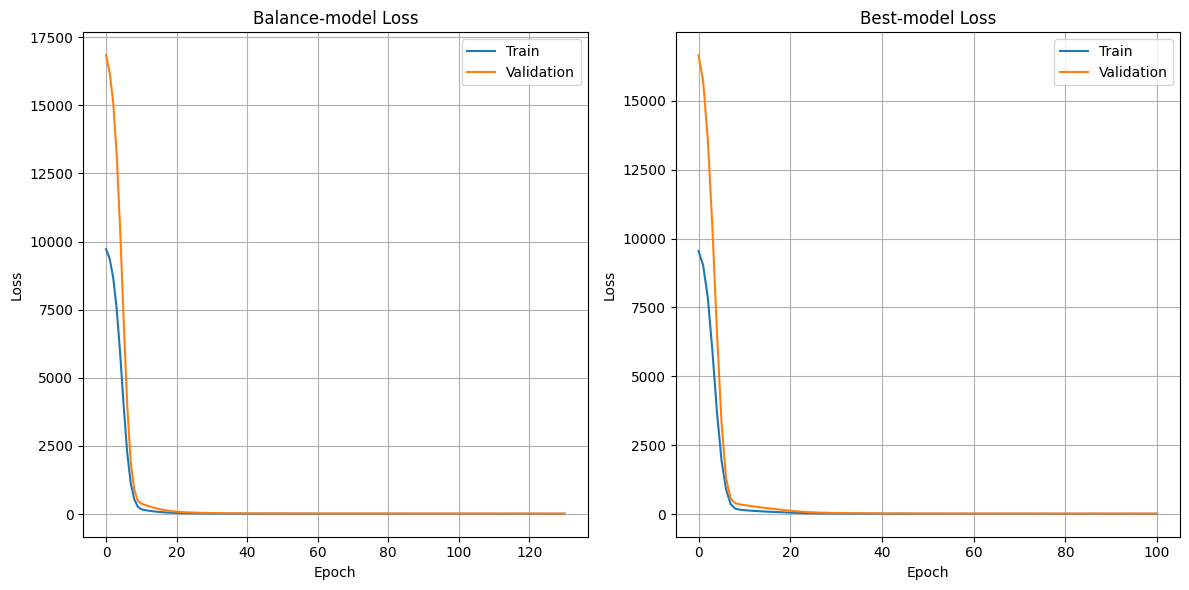

In [31]:
# Построение графиков функции потерь
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(balance_history.history['loss'])
plt.plot(balance_history.history['val_loss'])
plt.title('Balance-model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(best_history.history['loss'])
plt.plot(best_history.history['val_loss'])
plt.title('Best-model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)

plt.tight_layout()  # Для более компактного расположения
plt.show()

In [32]:
print('R2_balance:', balance_r2.round(5))
print('Число нейронов на слое 1 для balance-модели:', balance_num_neurons_1)
print('Число нейронов на слое 2 для balance-модели:', balance_num_neurons_2)
print('Значение seed для balance-модели:', balance_seed)
print()
print('R2_best:',    best_r2.round(5))
print('Число нейронов на слое 1 для лучшей модели:',  best_num_neurons_1)
print('Число нейронов на слое 2 для лучшей модели:',  best_num_neurons_2)
print('Значение seed для best-модели:',    best_seed)

R2_balance: 0.99115
Число нейронов на слое 1 для balance-модели: 20
Число нейронов на слое 2 для balance-модели: 12
Значение seed для balance-модели: 1901

R2_best: 0.99118
Число нейронов на слое 1 для лучшей модели: 24
Число нейронов на слое 2 для лучшей модели: 12
Значение seed для best-модели: 1900


In [33]:
y_NN_pred_balance = balance_model.predict(X_test_std)
y_NN_pred_train_balance = balance_model.predict(X_train_std)

rmse_NN_train_balance = np.sqrt(mean_squared_error(y_train, y_NN_pred_train_balance)).round(3)
rmse_NN_test_balance = np.sqrt(mean_squared_error(y_test, y_NN_pred_balance)).round(3)
mae_NN_train_balance = mean_absolute_error(y_train, y_NN_pred_train_balance).round(3)
mae_NN_test_balance = mean_absolute_error(y_test, y_NN_pred_balance).round(3)
r2_NN_train_balance = r2_score(y_train, y_NN_pred_train_balance).round(3)
r2_NN_test_balance = r2_score(y_test, y_NN_pred_balance).round(3)

b_max_NN_balance = balance_model.predict(A_max_std)[:].flatten()
b_max_NN_complex_balance = complex(b_max_NN_balance[0], b_max_NN_balance[1])
b_max_NN_modul_balance = np.abs(b_max_NN_complex_balance)
b_max_NN_arg_balance = np.angle(b_max_NN_complex_balance) * 180 / np.pi
metrics['NeuralNet_balance'] = (str(r2_NN_train_balance), str(r2_NN_test_balance), np.round(b_max_NN_complex_balance, 1), str(b_max_NN_modul_balance.round(1)), str(b_max_NN_arg_balance.round(1)))
metrics_opt['NeuralNet_balance'] = (str(r2_NN_train_balance), str(r2_NN_test_balance), np.round(b_max_NN_complex_balance, 1), str(b_max_NN_modul_balance.round(1)), str(b_max_NN_arg_balance.round(1)))

y_NN_pred = best_model.predict(X_test_std)
y_NN_pred_train = best_model.predict(X_train_std)

rmse_NN_train = np.sqrt(mean_squared_error(y_train, y_NN_pred_train)).round(3)
rmse_NN_test = np.sqrt(mean_squared_error(y_test, y_NN_pred)).round(3)
mae_NN_train = mean_absolute_error(y_train, y_NN_pred_train).round(3)
mae_NN_test = mean_absolute_error(y_test, y_NN_pred).round(3)
r2_NN_train = r2_score(y_train, y_NN_pred_train).round(3)
r2_NN_test = r2_score(y_test, y_NN_pred).round(3)

b_max_NN = best_model.predict(A_max_std)[:].flatten()
b_max_NN_complex = complex(b_max_NN[0], b_max_NN[1])
b_max_NN_modul = np.abs(b_max_NN_complex)
b_max_NN_arg = np.angle(b_max_NN_complex) * 180 / np.pi
metrics['NeuralNet_best'] = (str(r2_NN_train), str(r2_NN_test), np.round(b_max_NN_complex, 1), str(b_max_NN_modul.round(1)), str(b_max_NN_arg.round(1)))
metrics_opt['NeuralNet_best'] = (str(r2_NN_train), str(r2_NN_test), np.round(b_max_NN_complex, 1), str(b_max_NN_modul.round(1)), str(b_max_NN_arg.round(1)))

19/19 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 32ms/step


In [34]:
print(f'Метрики для balance-модели:')
print(f'RMSE train: {rmse_NN_train_balance}')
print(f'RMSE test:  {rmse_NN_test_balance}')
print()
print(f'MAE train:  {mae_NN_train_balance}')
print(f'MAE test:   {mae_NN_test_balance}')
print()
print(f'R2 train:   {r2_score(y_train, y_NN_pred_train_balance).round(6)}')
print(f'R2 test:    {r2_score(y_test, y_NN_pred_balance).round(6)}')
print()
print(f'Метрики для best-модели:')
print(f'RMSE train: {rmse_NN_train}')
print(f'RMSE test:  {rmse_NN_test}')
print()
print(f'MAE train:  {mae_NN_train}')
print(f'MAE test:   {mae_NN_test}')
print()
print(f'R2 train:   {r2_score(y_train, y_NN_pred_train).round(6)}')
print(f'R2 test:    {r2_score(y_test, y_NN_pred).round(6)}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex_balance: {np.round(b_max_NN_complex_balance, 1)}')
print(f'b max_modul_balance:   {b_max_NN_modul_balance.round(1)}')
print()
print(f'b max_complex_best:    {np.round(b_max_NN_complex, 1)}')
print(f'b max_modul_best:      {b_max_NN_modul.round(1)}')

Метрики для balance-модели:
RMSE train: 3.196
RMSE test:  3.358

MAE train:  2.549
MAE test:   2.733

R2 train:   0.992355
R2 test:    0.991152

Метрики для best-модели:
RMSE train: 3.285
RMSE test:  3.352

MAE train:  2.616
MAE test:   2.697

R2 train:   0.99192
R2 test:    0.991182

Прогноз целевой переменной:
b max_complex_balance: (152.1+454.7j)
b max_modul_balance:   479.5

b max_complex_best:    (131.5+446.4j)
b max_modul_best:      465.4


15. Определение коэффициента регуляризации alpha методом обобщенной невязки

In [35]:
# Функция вычисления обобщенной невязки delta_residual
def calculate_delta_residual(alpha, X, y, h, d):
    z = np.linalg.inv(X.T @ X + alpha * np.eye(X.shape[1])) @ X.T @ y
    residual = np.linalg.norm(X @ z - y)
    norm = np.linalg.norm(z)
    delta_residual = residual**2 - (h * norm + d)**2

    return delta_residual


X_h = X_train_std
y_d = y_train
# Вычисление точности задания матрицы A: h = ||A - A_h|| и вектора b: d = ||b - b_d||
h = k_A * np.linalg.norm(X_h)
d = k_b * np.linalg.norm(y_d)

# Поиск коэффициента регуляризации alpha
calculate_delta_residual_partial = partial(calculate_delta_residual, X=X_h, y=y_d, h=h, d=d)
# alpha = newton(calculate_delta_residual_partial, x0=1e-7, tol=1e-7, maxiter=1000)
# alpha = bisect(calculate_delta_residual_partial, 1e-7, 1e5)
alpha = brentq(calculate_delta_residual_partial, a=1e-7, b=1e5, xtol=1e-7)

print(f"Коэффициент регуляризации alpha = {alpha:.{2}e}")

Коэффициент регуляризации alpha = 1.60e+02


16. Регуляризированное решение системы уравнений

In [36]:
# Регуляризованное решение
z_hd = np.linalg.inv(X_h.T @ X_h + alpha * np.eye(X_h.shape[1])) @ X_h.T @ y_d

y_reg_hd_pred = X_test_std @ z_hd
y_reg_hd_pred_train = X_train_std @ z_hd

rmse_reg_hd_train = np.sqrt(mean_squared_error(y_train, y_reg_hd_pred_train)).round(3)
rmse_reg_hd_test = np.sqrt(mean_squared_error(y_test, y_reg_hd_pred)).round(3)
mae_reg_hd_train = mean_absolute_error(y_train, y_reg_hd_pred_train).round(3)
mae_reg_hd_test = mean_absolute_error(y_test, y_reg_hd_pred).round(3)
r2_reg_hd_train = r2_score(y_train, y_reg_hd_pred_train).round(3)
r2_reg_hd_test = r2_score(y_test, y_reg_hd_pred).round(3)

b_max_reg_hd = np.dot(np.array(A_max_std), np.array(z_hd))
b_max_reg_hd_complex = complex(b_max_reg_hd[0], b_max_reg_hd[1])
b_max_reg_hd_modul = np.abs(b_max_reg_hd_complex)
b_max_reg_hd_arg = np.angle(b_max_reg_hd_complex) * 180 / np.pi
metrics['Regularized'] = (str(r2_reg_hd_train), str(r2_reg_hd_test), np.round(b_max_reg_hd_complex, 1), str(b_max_reg_hd_modul.round(1)), str(b_max_reg_hd_arg.round(1)))
metrics_opt['Regularized'] = (str(r2_reg_hd_train), str(r2_reg_hd_test), np.round(b_max_reg_hd_complex, 1), str(b_max_reg_hd_modul.round(1)), str(b_max_reg_hd_arg.round(1)))

print(f'RMSE train: {rmse_reg_hd_train}')
print(f'RMSE test:  {rmse_reg_hd_test}')
print()
print(f'MAE train:  {mae_reg_hd_train}')
print(f'MAE test:   {mae_reg_hd_test}')
print()
print(f'R2 train:   {r2_reg_hd_train}')
print(f'R2 test:    {r2_reg_hd_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b_max_reg_hd_complex: {np.round(b_max_reg_hd_complex, 1)}')
print(f'b_max_reg_hd_modul:   {b_max_reg_hd_modul.round(1)}')
print()

df_z_hd = pd.DataFrame(z_hd)
file_path = 'C:\Datasets/dataset_z_hd.xlsx'
df_z_hd.to_excel(file_path, index=False, float_format='%.20f')

z_hd_xy = z_hd.values.flatten()
z_hd_real = z_hd_xy[:len(A_symcomp_max)]
z_hd_imag = z_hd_xy[len(A_symcomp_max):]
print(f'Масштабированные коэффициенты регрессии после регуляризации:')
pd.DataFrame({'z_real': z_hd_real, 'z_imag': z_hd_imag}).T.round(1)

RMSE train: 6.963
RMSE test:  6.834

MAE train:  5.395
MAE test:   5.317

R2 train:   0.964
R2 test:    0.963

Прогноз целевой переменной:
b_max_reg_hd_complex: (158.1+450.5j)
b_max_reg_hd_modul:   477.4

Масштабированные коэффициенты регрессии после регуляризации:


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
z_real,-2.7,11.8,-3.3,-3.0,11.6,0.8,0.3,14.7,0.1,-0.2,...,-0.5,2.0,12.1,-0.4,-3.6,13.4,-0.7,-2.1,13.8,-4.4
z_imag,-3.2,9.9,-2.2,0.5,9.9,-3.4,-0.1,8.4,-0.2,0.7,...,2.2,-0.9,9.8,2.5,0.2,9.1,-3.3,-4.0,8.9,-0.5


17. Условно точный прогноз целевой переменной b

In [37]:
# Создание вектора взаимных сопротивлений ЛЭП
z_acc = ()

for key in z_complex_acc:
    values = z_complex_acc[key]
    z_acc += tuple(values)

b_max_acc_complex = np.dot(np.array(A_complex_max), np.array(z_acc))
b_max_acc_modul = np.abs(b_max_acc_complex)
b_max_acc_arg = np.angle(b_max_acc_complex) * 180 / np.pi
metrics['Accurate'] = ('', '', b_max_acc_complex.round(1), b_max_acc_modul.round(1), str(b_max_acc_arg.round(1)))
metrics_opt['Accurate'] = ('', '', b_max_acc_complex.round(1), b_max_acc_modul.round(1), str(b_max_acc_arg.round(1)))

print(f'Условно точный прогноз целевой переменной по известным точным коэффициентам регрессии:')
print(f'b_max_acc_complex: {b_max_acc_complex.round(1)}')
print(f'b_max_acc_modul:   {b_max_acc_modul.round(3)}')

Условно точный прогноз целевой переменной по известным точным коэффициентам регрессии:
b_max_acc_complex: (163.4+508.1j)
b_max_acc_modul:   533.747


18. Максимально возможное значение целевой переменной

In [38]:
# Формирование матрицы I_max (для последующего масштабирования обученным скэлером)
I_max = [val for a_n, a_k in zip(I1_N, I1_K) for val in [a_n, a_n * k_N_2, 3 * a_n * k_N_0, a_k, a_k * k_K_2, 3 * a_k * k_K_0]]
I_max_real = np.array(I_max).real
I_max_imag = np.array(I_max).imag
I_max_1 = pd.concat([pd.DataFrame(I_max_real), -1 * pd.DataFrame(I_max_imag)], axis=0)
I_max_2 = pd.concat([pd.DataFrame(I_max_imag), pd.DataFrame(I_max_real)], axis=0)
index_max = np.arange(I_max_1.shape[0])
I_max_1.index = index_max
I_max_2.index = index_max 
I_max = pd.merge(I_max_1, I_max_2, left_index=True, right_index=True)
I_max = I_max.T
I_max

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0_x,1200.0,120.0,180.0,1100.0,99.0,148.5,1000.0,100.0,150.0,900.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
0_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,210.0,1300.0,117.0,175.5,1000.0,100.0,150.0,900.0,81.0,121.5


In [39]:
# Масштабирование матрицы I_max
I_max_std = sc.transform(np.abs(I_max))
pd.DataFrame(I_max_std).round(3)

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,28.854,0.047,13.952,25.277,0.041,12.199,43.038,0.079,22.217,76.129,...,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,7.695,38.048,0.032,14.96,49.268,0.078,22.035,47.301,0.067,20.101


In [40]:
# Вычисление модуля масштабированного вектора I_max
I_max_std_modul = I_max_std[0,:len(A_symcomp_max)]

z_hd_modul = np.sqrt(z_hd_real**2 + z_hd_imag**2)

# Вычисление максимально возможного значения целевой переменной
U_max_modul = np.dot(np.array(I_max_std_modul), np.array(z_hd_modul))

print(f'Максимально возможное значение целевой переменной:')
print(f'U_max_modul:   {U_max_modul.round(1)}')

Максимально возможное значение целевой переменной:
U_max_modul:   1336.1


19. Сводная таблица метрик и прогнозов моделей

In [41]:
df_metrics_GridSearchCV = pd.DataFrame(metrics)
df_metrics_GridSearchCV.index = ['R2 train', 'R2 test', 'b_max_complex', 'b_max_modul', 'b_max_arg, DEG']
df_metrics_GridSearchCV = df_metrics_GridSearchCV.astype(object)
df_metrics_Optuna = pd.DataFrame(metrics_opt)
df_metrics_Optuna.index = ['R2 train', 'R2 test', 'b_max_complex', 'b_max_modul', 'b_max_arg, DEG']
df_metrics_Optuna = df_metrics_Optuna.astype(object)

print(f'Коэффициент регуляризации alpha = {round(alpha, 1)}')
print(f'Максимально возможное значение U_max_modul = {round(U_max_modul, 1)}')

Коэффициент регуляризации alpha = 160.4
Максимально возможное значение U_max_modul = 1336.1


In [42]:
df_metrics_GridSearchCV

,LinearRegr,Ridge,SGDRegr,Lasso,ElasticNet,BayesianRidge,Mean_Result,NeuralNet_balance,NeuralNet_best,Regularized,Accurate
R2 train,0.993,0.992,0.992,0.992,0.992,0.992,0.992,0.992,0.992,0.964,
R2 test,0.991,0.991,0.991,0.991,0.991,0.991,0.991,0.991,0.991,0.963,
b_max_complex,(80.2+268.8j),(110.5+340.3j),(116.9+422.4j),(363.4+505.4j),(316+476j),(159.4+486.2j),(191.1+416.5j),(152.1+454.7j),(131.5+446.4j),(158.1+450.5j),(163.4+508.1j)
b_max_modul,280.5,357.8,438.2,622.5,571.4,511.7,458.2,479.5,465.4,477.4,533.7
"b_max_arg, DEG",73.4,72.0,74.5,54.3,56.4,71.9,65.4,71.5,73.6,70.7,72.2


In [43]:
df_metrics_Optuna

,LinearRegr,Ridge,SGDRegr,Lasso,ElasticNet,BayesianRidge,Mean_Result,NeuralNet_balance,NeuralNet_best,Regularized,Accurate
R2 train,0.993,0.992,0.984,0.991,0.986,0.992,0.989,0.992,0.992,0.964,
R2 test,0.991,0.991,0.983,0.99,0.985,0.991,0.988,0.991,0.991,0.963,
b_max_complex,(80.2+268.8j),(159.9+481.2j),(62.8+293.2j),(223+393.5j),(24.2+254.3j),(159.4+486.2j),(118.3+362.9j),(152.1+454.7j),(131.5+446.4j),(158.1+450.5j),(163.4+508.1j)
b_max_modul,280.5,507.1,299.9,452.3,255.4,511.7,381.6,479.5,465.4,477.4,533.7
"b_max_arg, DEG",73.4,71.6,77.9,60.5,84.6,71.9,72.0,71.5,73.6,70.7,72.2


In [44]:
end_time = time.time()
minutes, seconds = divmod(end_time - start_time, 60)

print(f'Время выполнения кода: {int(minutes)} минут(ы) {seconds:.1f} секунд(ы)')

Время выполнения кода: 76 минут(ы) 47.5 секунд(ы)
